# Transfer Learning

<!--<badge>--><a href="https://colab.research.google.com/github/SniperDW/github_actions/blob/main/Week 5/3- Transfer Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems.

We'll be using a pretrained model for the Cats vs Dogs dataset.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# The libraries below are built-into python and are used to work with local storage and directories
import os 

In [2]:
tf.random.set_seed(42)

### Download & Preprocess Data

First, we'll need to download and unzip the images, for that we'll be using the bang `!` keyword to run terminal commands, we'll use `wget` to download and `unzip` to extract files.

In [3]:
!!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip 

['--2021-01-29 13:34:14--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip',
 'Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 172.217.218.128, ...',
 'Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 68606236 (65M) [application/zip]',
 'Saving to: ‘cats_and_dogs_filtered.zip.1’',
 '',
 '',
 '          cats_and_   0%[                    ]       0  --.-KB/s               ',
 '         cats_and_d  61%[===========>        ]  40.01M   181MB/s               ',
 'cats_and_dogs_filte 100%[===================>]  65.43M   174MB/s    in 0.4s    ',
 '',
 '2021-01-29 13:34:14 (174 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]',
 '']

In [ ]:
!unzip cats_and_dogs_filtered.zip 

This is how the dataset directory is laid out:

```
cats_and_dogs_filtered
└───train
│   └───cats
│   │   │   cat.0.jpg
│   │   │   cat.1.jpg
│   │   │   ...
│   └───dogs
│       │   dog.0.jpg
│       │   dog.1.jpg
│       │   ...
└───validation
│   └───cats
│   │   │   cat.2000.jpg
│   │   │   cat.2001.jpg
│   │   │   ...
│   └───dogs
│       │   dog.2000.jpg
│       │   dog.2001.jpg
│       │   ...
```

We'll create a function that takes in the path of either the train or validation folders, loops over the folders and files inside it, and finally return a tuple of the image paths and image labels (i.e. the x's and y's).

In [5]:
def create_cats_vs_dogs_dataset_from_path(path):

  # Create the arrays that will hold the paths and labels
  image_paths = []
  image_labels = []
  
  # os.listdir returns an array of the files or directories in the specified path 
  for dir in os.listdir(path): # This loops over ['cats', 'dogs']
    for file in os.listdir(f"{path}/{dir}"): # This loops over all the images inside the directoy
      
      # Create the full path of the image
      image_path = f'{path}/{dir}/{file}'
      # Assign the label depending on the directory, 0 for cats and 1 for dogs
      image_label = 0 if dir == 'cats' else 1 

      # Append the image path and label to the arrays we defined earlier
      image_paths.append(image_path)
      image_labels.append(image_label)

  # Convert the arrays to Numpy arrays
  image_paths = np.array(image_paths)
  image_labels = np.array(image_labels)

  # Return the tuple
  return image_paths, image_labels

Now we'll use the function above to create the train and testing dataset by passing the path of the train and validation directories respectively.

In [6]:
image_paths_train, labels_train = create_cats_vs_dogs_dataset_from_path('/content/cats_and_dogs_filtered/train')
image_paths_test, labels_test = create_cats_vs_dogs_dataset_from_path('/content/cats_and_dogs_filtered/validation')

image_paths_train.shape, labels_train.shape, image_paths_test.shape, labels_test.shape

((2000,), (2000,), (1000,), (1000,))

Let's take a look at a few samples from the data we created so far

In [7]:
# We're splicing the middle of the numpy array to get both cats and dogs.
print("Training Image Paths:\n", image_paths_train[995:1005])
print("Training Image Labels:\n", labels_train[995:1005])

Training Image Paths:
 ['/content/cats_and_dogs_filtered/train/cats/cat.29.jpg'
 '/content/cats_and_dogs_filtered/train/cats/cat.901.jpg'
 '/content/cats_and_dogs_filtered/train/cats/cat.779.jpg'
 '/content/cats_and_dogs_filtered/train/cats/cat.367.jpg'
 '/content/cats_and_dogs_filtered/train/cats/cat.581.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.382.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.435.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.73.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.69.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.764.jpg']
Training Image Labels:
 [0 0 0 0 0 1 1 1 1 1]


### Create TensorFlow Data Pipeline

Now we're going to define the functions that will be used to create the pipeline, we'll first start with a function that takes an image path and label pair and returns the image tensor and the same label 

In [8]:
def get_image_tensor_from_path(image_path, label):

    image = tf.io.read_file(image_path) # Read and output the entire contents of the input file.
    image = tf.image.decode_jpeg(image) # Convert the content of the file to a 3D Tensor (height, width, color_channels).
    image = tf.image.convert_image_dtype(image, tf.float32) # Convert the tensor values (i.e. pixel brightness) to floats between 0 and 1
    image = tf.image.resize(image, (224,224)) # Resize the image to a fixed square size of 224 by 224

    return image, label

Next we'll define the image augmentation function that will apply random transformations to the image

In [9]:
# This is the same function that was defined in the CIFAR10 example

def augment_image(image, label):

  image = tf.image.random_flip_left_right(image) # Randomly flip an image horizontally
  image = tf.image.random_flip_up_down(image) # Randomly flips an image vertically
  image = tf.image.random_brightness(image, max_delta=32.0/255.0) # Adjust the brightness of images by a random factor
  image = tf.image.random_saturation(image, lower=0.5, upper=1.5) # Adjust the saturation of RGB images by a random factor
    
  # Make sure the image's pixel values are still between 0 and 1
  image = tf.clip_by_value(image, 0.0, 1.0)
    
  return image, label

And finally, the dataset creator function that will put everything together

In [10]:
def cat_v_dog_dataset_creator(x, y, batch_size = 32, training=False):

  data = tf.data.Dataset.from_tensor_slices((x,y))

  # Convert image paths to image tensors using get_image_tensor_from_path
  data = data.map(get_image_tensor_from_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

  if training: # If training == True then apply train preprocess on dataset, this makes sure that the validation dataset isn't augmented
    data = data.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) # Applying the augment_image function on dataset

  data = data.shuffle(2000) # Shuffle the data, `2000` represnts the buffer size, read the documentation for more details
  data = data.batch(batch_size) # Create mini-batches for the specified size

  # This allows later elements to be prepared while the current element is being processed.
  data = data.prefetch(tf.data.experimental.AUTOTUNE)

  return data

In [11]:
train_dataset = cat_v_dog_dataset_creator(image_paths_train, labels_train, training=True)
test_dataset = cat_v_dog_dataset_creator(image_paths_test, labels_test)

In the cell below, we'll take a batch from the `train_dataset` and show 25 samples from them to see the effect of the transformations.

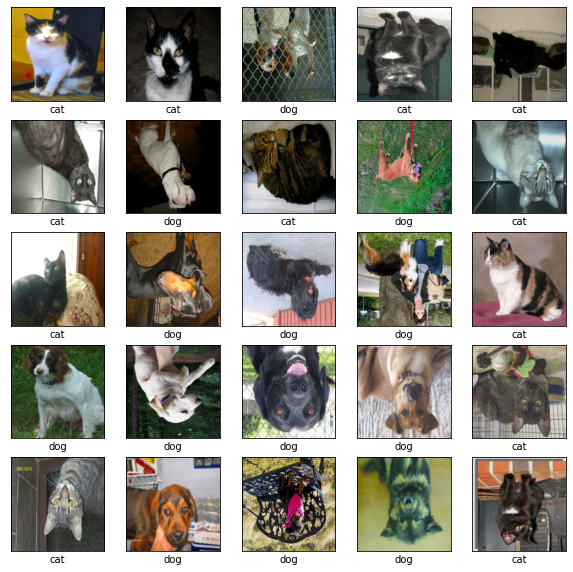

In [12]:
class_names = ['cat', 'dog']

for x, y in train_dataset.take(1):
  
  plt.figure(figsize=(10,10))
  
  for i in range(25):
    plt.subplot(5,5,i+1) # Create a subplot on a 5x5 grid for index i

    plt.xticks([]) # Remove the ticks of the number line from the x axis 
    plt.yticks([]) # Remove the ticks of the number line from the y axis 

    plt.imshow(x[i]) # Plot the image, no need to use the cmap parameter since this image is in RGB

    plt.xlabel(class_names[y[i]]) # Add the class name below the image 

## Loading Pretrained Model

The usual workflow for transfer learning is the following: 

1. Freeze all layers in the base model by setting trainable = False.
2. Create a new model on top of the output of one (or several) layers from the base model.
3. Train your new model on your new dataset.


Note that an alternative, more lightweight workflow could also be:

1. Instantiate a base model and load pre-trained weights into it.
2. Run your new dataset through it and record the output of one (or several) layers from the base model. This is called feature extraction.
3. Use that output as input data for a new, smaller model.

An issue with that workflow, though, is that it doesn't allow you to dynamically modify the input data of your new model during training, which is required when doing data augmentation, for instance. Transfer learning is typically used for tasks when your new dataset has too little data to train a full-scale model from scratch, and in such scenarios data augmentation is very important. So in what follows, we will focus on the first workflow.

In TensorFlow, we'll start by loading the pretrained model from `tf.keras.applications` API, a full list of available pretrained models can be found here: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [13]:
pretrained_model = tf.keras.applications.DenseNet121(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False # Do not include the ImageNet classifier at the top, we'll only be using the convolutional layers
)  

pretrained_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

Notice how there are ~7 millions trainable parameters, since we don't intend to tuning the existing weights, we'll set the `trainable` attribute of the pretrained model to `False` 

In [14]:
pretrained_model.trainable = False
pretrained_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

## Build & Train Model
In order to create a new model that leverages the pretrained model, we'll be using TensorFlow's Functional API instead of Sequential, more information on the Functional API can be found here: https://www.tensorflow.org/guide/keras/functional

In [15]:
inputs = tf.keras.Input(shape=(224, 224, 3))

# We make sure that the pretrained_model is running in inference mode here by passing `training=False`.
x = pretrained_model(inputs, training=False)

# Flatten the feature vectors to a single vector
x = tf.keras.layers.Flatten()(x)

# Create the feed-forward `Dense` part of the network
x = tf.keras.layers.Dense(128,activation=tf.nn.relu)(x)
x = tf.keras.layers.Dropout(0.1)(x)

# An output layer with a single unit (binary classification)
outputs = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)(x)

# Finally create the model by piecing together the layers between the input and output layers
model = tf.keras.Model(inputs, outputs)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               6422656   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 13,460,289
Trainable params: 6,422,785
Non-trainable params: 7,037,504
__________________________________________

In [17]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [18]:
model.fit(train_dataset, epochs=5,validation_data=test_dataset)

Epoch 1/5
63/63 [==============================] - 21s 127ms/step - loss: 6.7249 - accuracy: 0.7099 - val_loss: 0.0575 - val_accuracy: 0.9820
Epoch 2/5
63/63 [==============================] - 10s 84ms/step - loss: 0.1243 - accuracy: 0.9551 - val_loss: 0.0323 - val_accuracy: 0.9830
Epoch 3/5
63/63 [==============================] - 10s 84ms/step - loss: 0.0479 - accuracy: 0.9885 - val_loss: 0.0394 - val_accuracy: 0.9840
Epoch 4/5
63/63 [==============================] - 10s 85ms/step - loss: 0.0383 - accuracy: 0.9906 - val_loss: 0.0450 - val_accuracy: 0.9830
Epoch 5/5
63/63 [==============================] - 10s 84ms/step - loss: 0.0237 - accuracy: 0.9961 - val_loss: 0.0394 - val_accuracy: 0.9830


In comparision, our original model for a validation accuracy of 0.6420 after 20 epoches, so not only did transfer learning increase our model's accuracy, it did so in less training time.

## Plot Training History

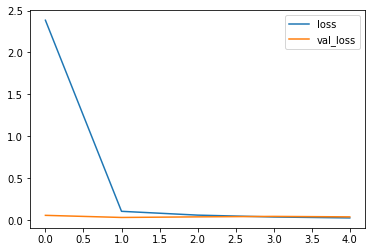

In [19]:
pd.DataFrame(model.history.history)[['loss', 'val_loss']].plot.line()